In [10]:
import numpy as np
import cv2 as cv

In [11]:
# delete all files in data folder
import os
import shutil

width = 64
height = 64

folder = "data"
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print("Failed to delete %s. Reason: %s" % (file_path, e))

# create folders
os.mkdir("data/circles")
os.mkdir("data/squares")
os.mkdir("data/triangles")

# generate images
n_images = 1000

# generate random radius and center
radius = np.random.randint(4, width//5, n_images)
center = np.random.randint(width//4, 3*width//4, (n_images, 2))
color = np.random.randint(100, 255, (n_images, 3))
thick = np.random.randint(2, 5, n_images)

# generate 32x32 images of circles
for i in range(n_images):
    img = np.zeros((width, height, 3), dtype="uint8")
    ccrd = center[i]
    r = radius[i]
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.circle(img, tuple(ccrd), r, co, t)
    # save image
    cv.imwrite(f"data/circles/{i:05d}.png", img)

# generate 32x32 images of squares
for i in range(n_images):
    img = np.zeros((width, height, 3), dtype="uint8")
    ccrd = center[i]
    r = int(radius[i]*1.3)
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.rectangle(img, (ccrd[0]-r, ccrd[1]-r), (ccrd[0]+r, ccrd[1]+r), co, t)
    # save image
    cv.imwrite(f"data/squares/{i:05d}.png", img)

# generate 32x32 images of triangles
for i in range(n_images):
    img = np.zeros((width, height, 3), dtype="uint8")
    ccrd = center[i]
    r = int(radius[i]*1.5)
    co = [int(a) for a in color[i]]
    t = thick[i]
    cv.line(img, (ccrd[0]-r, ccrd[1]-r), (ccrd[0]+r, ccrd[1]-r), co, t)
    cv.line(img, (ccrd[0]+r, ccrd[1]-r), (ccrd[0], ccrd[1]+r), co, t)
    cv.line(img, (ccrd[0], ccrd[1]+r), (ccrd[0]-r, ccrd[1]-r), co, t)
    # save image
    cv.imwrite(f"data/triangles/{i:05d}.png", img)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
transfo = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder(root='data', transform=transfo)
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)

torch.Size([128, 3, 64, 64]) tensor([1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 1, 2, 2, 1, 1, 2, 1, 1, 2, 0, 0,
        2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 2, 2,
        1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 2, 1, 0, 2, 2, 1, 2,
        2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 1,
        2, 2, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 0, 0, 2, 0, 0,
        1, 1, 0, 0, 1, 2, 1, 1])


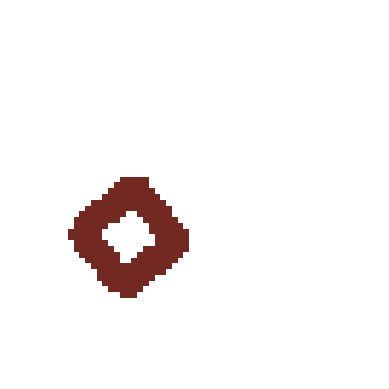

In [14]:
for image, label in dataset_loader:
    print(image.shape, label)
    # display image
    plt.imshow((1-image[0]).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    break

In [15]:
image.min(), image.max()

(tensor(0.), tensor(0.9961))

In [16]:
# define a FC network 32x32 to 3 classes
class ShapeNet(nn.Module):
    def __init__(self, hidden_size=100):
        super(ShapeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, stride=1) # 64x64 -> 60x60
        self.conv2 = nn.Conv2d(8, 16, 5, stride=1) # 60x60 -> 56x56
        self.conv3 = nn.Conv2d(16, 32, 2, stride=2) # 56x56 -> 28x28
        self.fc1 = nn.Linear(28*28*32, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(-1, 28*28*32)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [17]:
# create model + optimizer
model = ShapeNet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# loss function
criterion = nn.CrossEntropyLoss()
num_epochs = 40
losses = []

In [18]:
# train the model
for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    for image, label in dataset_loader:
        image = image.to(device)
        label = label.to(device)
        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss:.4f}')

Epoch [1/40], Loss: 26.3461
Epoch [2/40], Loss: 25.1965
Epoch [3/40], Loss: 24.8518
Epoch [4/40], Loss: 24.5592
Epoch [5/40], Loss: 24.4198
Epoch [6/40], Loss: 23.9337
Epoch [7/40], Loss: 23.6300
Epoch [8/40], Loss: 22.3143
Epoch [9/40], Loss: 21.9269
Epoch [10/40], Loss: 20.9624
Epoch [11/40], Loss: 19.9026
Epoch [12/40], Loss: 19.2330
Epoch [13/40], Loss: 18.8160
Epoch [14/40], Loss: 18.5294
Epoch [15/40], Loss: 18.1793
Epoch [16/40], Loss: 17.8406
Epoch [17/40], Loss: 17.3821
Epoch [18/40], Loss: 17.1708
Epoch [19/40], Loss: 16.9526
Epoch [20/40], Loss: 16.3257
Epoch [21/40], Loss: 16.1939
Epoch [22/40], Loss: 16.0043
Epoch [23/40], Loss: 15.7164
Epoch [24/40], Loss: 15.4381
Epoch [25/40], Loss: 15.3551
Epoch [26/40], Loss: 14.8811
Epoch [27/40], Loss: 15.0182
Epoch [28/40], Loss: 14.8347
Epoch [29/40], Loss: 14.5550
Epoch [30/40], Loss: 14.5969
Epoch [31/40], Loss: 14.5165
Epoch [32/40], Loss: 14.5976
Epoch [33/40], Loss: 14.3719
Epoch [34/40], Loss: 14.1803
Epoch [35/40], Loss: 14

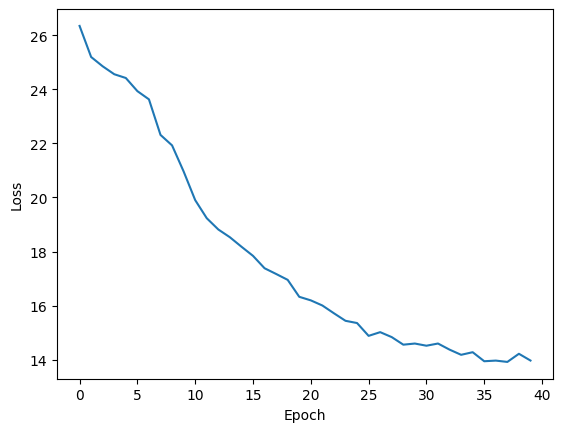

In [19]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

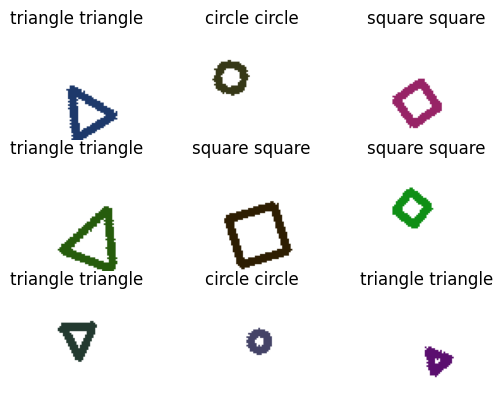

Accuracy: 96.40 %


In [20]:
class_names = ['circle', 'square', 'triangle']
plot=True
correct = 0
total = 0
for images, labels in dataset_loader:
    predictions = model(images)
    if plot:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(1-images[i].numpy().swapaxes(0, 2).swapaxes(0, 1))
            pred_class = class_names[torch.argmax(predictions[i])]
            plt.title(class_names[labels[i]] + " " + pred_class)
            plt.axis("off")
        plt.show()
        plot=False
    total += labels.size(0)
    correct += (torch.argmax(predictions, dim=1) == labels).sum().item()

print(f"Accuracy: {100*correct/total:.2f} %")

In [21]:
# export as onnx model
dummy_input = image[:1]
torch.onnx.export(model, dummy_input, "shape_reco.onnx", export_params=True, verbose=True)

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

